<table style="width:100%">
  <tr style="background-color:#002147">
    <th><p style="color:white">Professional Programme, Department of Computer Science, University of Oxford</th> 
  </tr>
</table>

# Things of the Internet (TOI)

## LAB 4: Cloud or Edge

Please note the submission deadline for this report is Wednesday 23:59 PM, March 25th, 2021.

Your name:

###  Introduction

In the Industrial IOT, monitoring the behaviour of machines (in particular motors) is of key importance for predictive maintenance. In this lab, we will investigate the relative merits of processing data on the cloud compared with on the device (edge) and the relative impacts in terms of communication load and energy consumption.

As an example, consider monitoring irrigation pumps on a smart farm, to enable precision agriculture. Knowing that a pump has failed or has an issue is key to improving efficiency. Ideally, given sufficient training data, it may even be possible to detect a failure before it even happens.

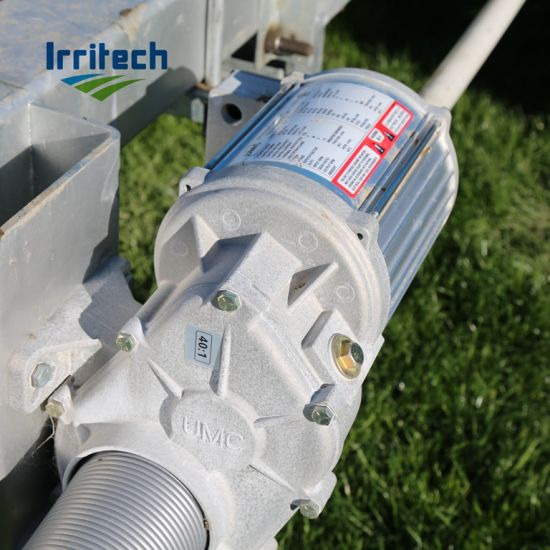

### Vibration sensing: a primer
A simple way of measuring the behaviour of a machine is to assess its levels of vibration. We can build a model of the machine (a so-called digital twin) and determine whether levels of vibration are within bounds or excessively high. The performance of the detection algorithm is what sets apart techniques.

There are many ways of measuring vibration such as using a microphone (acoustic condition monitoring) or using an accelerometer. In this lab, we will consider the latter, but the techniques described here are generic enough to be used for different types of signals.

We have been supplied with some sample datasets [trainA.csv] and [testA.csv]. Use a text-editor to open one and examine the contents. Each line consists of a label (0,1 or 2) and 100 samples (corresponding to 1 second of data). The label represents the operating conditions:

- 0: NORMAL: normal
- 1: FAULT: an issue with the motor
- 2: ERROR: an issue with the sensor e.g. it is not properly attached to the motor assembly

Our goal is to try and develop some algorithms that can analyse this data, so we can identify failing motors. We can then deploy our product and start printing money.

Run the code snippet below to build the training dataset

In [9]:
import csv
import numpy
f = open('trainA.csv')
reader = csv.reader(f)
train_labels = []
train_dataset = []
for row in reader:
    if len(row)>0:
        label = int(float(row[0]))
        data = numpy.asarray(row[1:],dtype='float')
        train_labels.append(label)
        train_dataset.append(data)
f.close()

f = open('testA.csv')
reader = csv.reader(f)
test_labels = []
test_dataset = []
for row in reader:
    if len(row)>0:
        label = int(float(row[0]))
        data = numpy.asarray(row[1:],dtype='float')
        test_labels.append(label)
        test_dataset.append(data)
f.close()

Use pylab to plot sample data for a sample of each condition (NORMAL, FAULT, ERROR). A snippet has been provided below for you to start with.

```python
import pylab
pylab.plot(data)
pylab.show()
```

<div class="alert alert-block alert-info">
<b>Question:</b> Can you visually tell them apart?
</div>

Your answer: No, it is not easy at all. They look visually very similar.

2


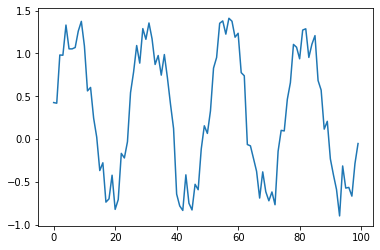

1


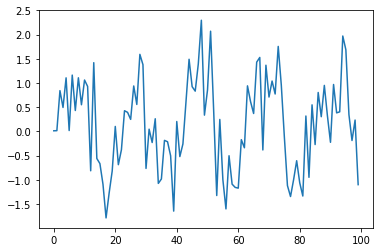

2


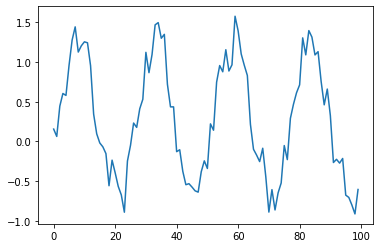

2


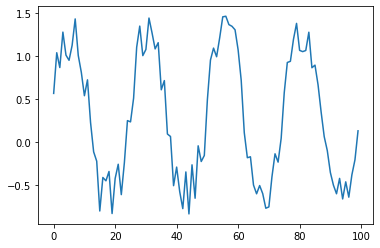

2


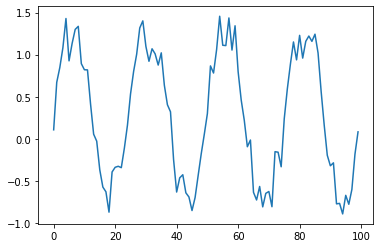

0


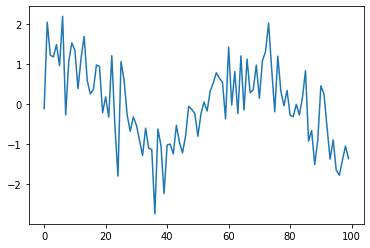

1


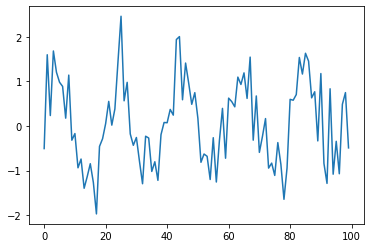

2


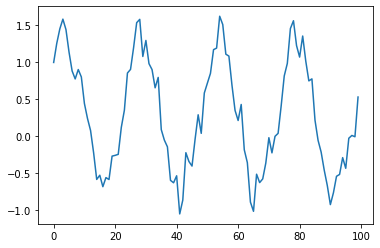

1


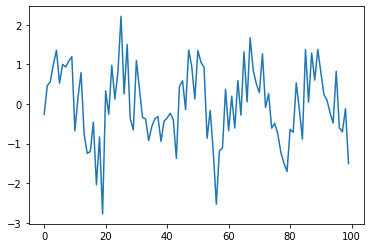

2


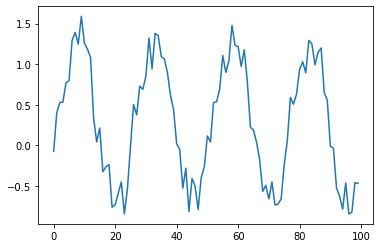

In [10]:
import pylab
for i in range(0, 10):
    print(train_labels[i])
    pylab.plot(train_dataset[i])
    pylab.show()

## Cloud based classifier

We start first with the typical approach to IoT deployments: all data will get sent to the cloud, where it will be analysed with state-of-the-art machine learning algorithms. This allows us to extract the maximum value of the data, and provide analytics about device behaviour.

We are going to use a black-box machine learning classifier: a Random Forest. This is often termed the "swiss-army" knife of classifiers, as it uses an ensemble of decision trees to learn relationships between data. We don't need to understand the details of how it works, we just use it as a black-box.

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#Create a random forest classifier
clf=RandomForestClassifier(n_estimators=100,random_state=101)
# Train the model
clf.fit(train_dataset,train_labels)
# Test how well it works
y_pred=clf.predict(test_dataset)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))

Accuracy: 0.993


<div class="alert alert-block alert-info">
<b>Question:</b> Comment on the accuracy that you achieve. What are the implications of any inaccuracies? Do you think it is sufficient for the application setting?
</div>

Your answer: The accuracy is very high and for many systems this may be sufficient. However, consider the cost of a false positive or equally a false negative response. A false positive may result in an engineer having to visit the machine, which could be costly. Or a false negative could result in a broken motor and consequent downtime. Although ~99% accuracy is very high, it still means that 1 out of 100 predictions is wrong. If you have thousands, or even millions of motors to look at, this could be too low. An accuracy in the order of 99.99% would be preferable...

The sensor node is connected to a central IoT gateway, using a long-range narrowband transceiver (LORA).

Assume that the sensor takes 100 samples every second i.e. one row in your dataset. This consumes 1 unit of energy. Computation takes a further 2 units of energy. Transmission takes 0.03 units of energy per byte sent. Assume each sample is represented as a 32 bit float.

<div class="alert alert-block alert-info">
<b>Question:</b> What is the energy consumed per second for this setting?
</div>

Your answer: 1 sample = 4 bytes, data per second = 100 samples = 400 bytes, which takes 12 units of energy for transmission So the total energy consumed per second = 15 units

Assume that the sensor is equipped with a battery with a capacity of 100M units of energy.

<div class="alert alert-block alert-info">
<b>Question:</b> How many days will the device last before the battery is exhausted?
</div>

Your answer: 100M/15 seconds = 77 days

<div class="alert alert-block alert-info">
<b>Question:</b> What simple techniques could you use to reduce the amount of energy consumed?
</div>

Your answer: We need to reduce the volume of data sent to the cloud. Rather than representing each sample as 4 bytes, we can consider if we really need that level of precision. For example, it may be sufficient to reduce it to 8 bit (1 byte) per sample. This would quarter the amount of data needed. We could also investigate whether a sampling rate of 100 Hz is really necessary and if a sampling rate of 50 Hz would be sufficient. Another alternative would be to use some sort of lossy or lossless compression to take advantage of redundancy in the data.

<div class="alert alert-block alert-success">
<b> Advanced Question:</b> (optional) Implement your technique and using the black box random forest predictor above, check to see the impact on accuracy. What is the impact on your overall system lifetime?
</div>

Your answer: To consider the impact of reducing the bit width, the dataset can simply be scaled, represented as a byte and then the random forest classifier rerun. For this dataset, reducing to 8 bit does not greatly impact accuracy, but would dramatically increase lifetime: 6 units of energy (3 for transmission, 3 for CPU and sensing) would increase lifetime to 192 days.

In [4]:
import csv
import numpy
f = open('trainA.csv')
reader = csv.reader(f)
train_labels = []
train_dataset = []
for row in reader:
    if len(row)>0:
        label = int(float(row[0]))
        data = numpy.asarray(row[1:],dtype='float')
        train_labels.append(label)
        train_dataset.append(data)
train_dataset = numpy.array(train_dataset)
f.close()

f = open('testA.csv')
reader = csv.reader(f)
test_labels = []
test_dataset = []
for row in reader:
    if len(row)>0:
        label = int(float(row[0]))
        data = numpy.asarray(row[1:],dtype='float')
        test_labels.append(label)
        test_dataset.append(data)
test_dataset = numpy.array(test_dataset)
f.close()

#scale
min_value = numpy.min(train_dataset)
max_value = numpy.max(train_dataset)
train_dataset = (train_dataset - min_value)/(max_value - min_value)*256
train_dataset = numpy.array(train_dataset, dtype=numpy.uint8)
    
for i in range(0, test_dataset.shape[0]):
    for j in range(0, test_dataset.shape[1]):
        test_dataset[i][j] = (test_dataset[i][j] - min_value)/(max_value - min_value)*256
        if test_dataset[i][j] < 0:
            test_dataset[i][j] = 0
        if test_dataset[i][j] > 255:
            test_dataset[i][j] = 255
test_dataset = numpy.array(test_dataset, dtype=numpy.uint8)


from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#Create a random forest classifier
clf=RandomForestClassifier(n_estimators=100,random_state=101)
# Train the model
clf.fit(train_dataset,train_labels)
# Test how well it works
y_pred=clf.predict(test_dataset)
# Model Accuracy, how often is the classifier correct?
print("Accuracy:",metrics.accuracy_score(test_labels, y_pred))

Accuracy: 0.993


The random forest has 100 estimators, each of which is a decision tree. The total number of parameters to store the tree depends on the depth and breadth of the tree which is randomly constructed, but typically there are about ~20k parameters in this black box, with a model size of 80 kbyte. This is quite a small model to run on the cloud, but is a significant cost to run every second on an end node, if it even is possible.

## Edge based classifier

Rather than pushing all the data to the cloud, we are going to explore what the tradeoffs are in processing the data on the device itself. Clearly, running a black-box classifier like a random forest is very expensive on the device, so your job is to design a more computationally efficient approach.

To design your own classifier, you can consider extracting some statistical features like the mean, the min/max, the standard deviation etc. The code below might help you get started.

```python
mean = numpy.mean(data)
median = numpy.median(data)
max = numpy.max(data)
min = numpy.min(data)
standard_deviation = numpy.std(data)
```

<div class="alert alert-block alert-info">
<b>Question:</b> Design a classifier that returns a class label (e.g. 0, 1 or 2) when given a sample. What is the accuracy of your classifier? [HINT: if you get really stuck, skip to the next question]
</div>

Your answer: Here is a dirty classifier (using Naive Bayes) that uses raw stastical features like the median and mean. The resultant accuracy is low, because there is a large amount of confusion (misclassification) between two classes.

In [5]:
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
import numpy as np
train_features = []
for i in range(0,len(train_dataset)):
    data = train_dataset[i]
    train_features.append([np.mean(data),np.median(data),np.max(data),np.min(data),np.std(data)])
clf = GaussianNB()
clf.fit(train_features, train_labels)
test_features = []
for i in range(0,len(test_dataset)):
    data = test_dataset[i]
    test_features.append([np.mean(data),np.median(data),np.max(data),np.min(data),np.std(data)])
predicted_labels = clf.predict(test_features)
print("Accuracy:",metrics.accuracy_score(test_labels, predicted_labels))

Accuracy: 0.881


Rather than time-domain statistical operations, it often helps to transform the data to the frequency domain, to extract the signals in each frequency band. A common, and computationally efficient, technique for this is to use the Fast Fourier Transform. This converts the time series to energy bands. By transforming to a different domain, it is often easier to design a simpler classifier.

Copy and paste the snippet of code below into a block. This plots the FFT magnitude for the first 10 samples in the training dataset. Can you visually see some difference between the classes? Please do not forget to reload the train and test dataset if you have altered the dataset in previous questions.

```python
import pylab
for k in range(10):
    data = train_dataset[k]
    label = train_labels[k]
    features = numpy.abs(numpy.fft.fftshift(numpy.fft.fft(data)))
    pylab.plot(features)
    pylab.title("class:"+str(label))
    pylab.show()
```

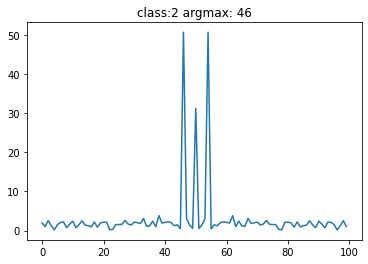

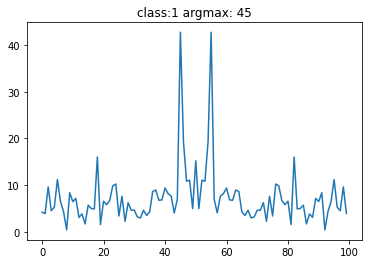

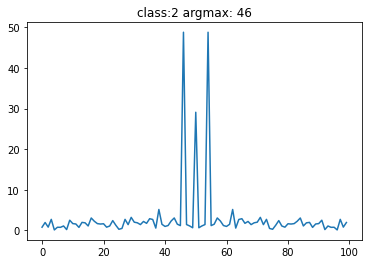

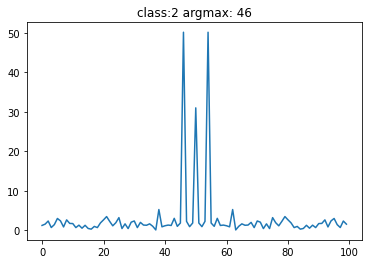

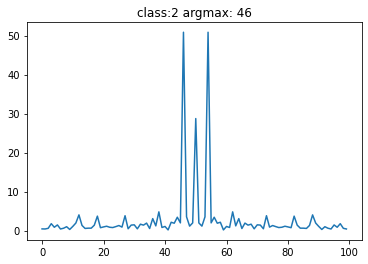

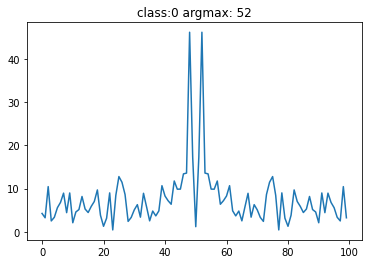

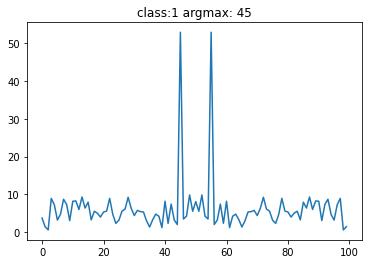

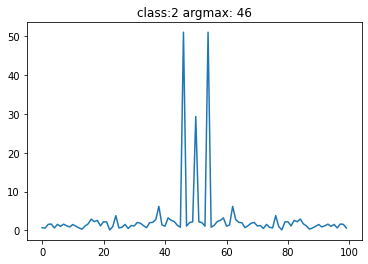

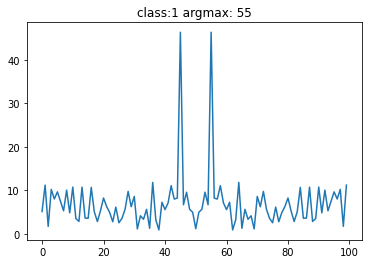

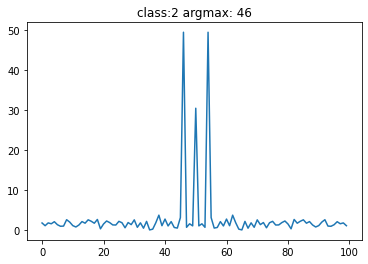

In [12]:
import pylab
import numpy as np
for k in range(10):
    data = train_dataset[k]
    label = train_labels[k]
    features = numpy.abs(numpy.fft.fftshift(numpy.fft.fft(data)))
    pylab.plot(features)
    pylab.title("class:"+str(label)+" argmax: "+str(np.argmax(features)))
    pylab.show()

<div class="alert alert-block alert-info">
<b>Question:</b> Design a classifier that returns a class label (e.g. 0, 1 or 2) when given a sample. What is the accuracy of your classifier? Do you think that this accuracy is sufficient for the application at hand?
</div>

Your answer: The simplest approach is just to look at the argmax() i.e. the peak frequency for each class. Visually, it can be seen that class 0 is easily distinguished from classes 1 and 2, but it is hard to tell 1 and 2 apart. The accuracy is around 50-60%, depending on the implementation. This accuracy is not sufficient for the application.

In [13]:
predicted_labels = []
test_features = []
for i in range(0,len(test_dataset)):
    data = test_dataset[i]
    fft_res = numpy.abs(numpy.fft.fftshift(numpy.fft.fft(data)))
    if np.argmax(fft_res) <= 52 and np.argmax(fft_res) >= 48:
        predicted_labels.append(0)
    else:
        # just predict label 1 or 2 at random
        predicted_labels.append(np.random.randint(1,3))
print("Accuracy:",metrics.accuracy_score(test_labels, predicted_labels))

Accuracy: 0.672


<div class="alert alert-block alert-info">
<b>Question:</b> Using the same assumptions as above, what is the device lifetime using the edge based classifier? 
</div>

Your answer: If we assume that this adds neglible computational load, transmitting one byte to represent the class label per unit time would result in a power consumption just above 3 units per unit time. The lifetime is extended approximately 5 times beyond the initial cloud-based classifier.

## Hybrid based approach

The testing dataset that you have used (TestA.csv) is balanced i.e. there are equal numbers of each sample (NORMAL, FAULT, ERROR).

<div class="alert alert-block alert-info">
<b>Question:</b> Do you think this is the reality for detecting condition based anomalies? 
</div>


Your answer: In reality, it is most likely that samples are NORMAL and ERROR/FAULT would be the exception. This results in an unbalanced real dataset. This does make testing/training complex though, as a naive detector which always outputs NORMAL will achieve high levels of accuracy.

A more reflective dataset has been created, which more closely reflects real data. Use the following code snippet to load it:

In [14]:
f = open('testB.csv')
reader = csv.reader(f)
real_labels = []
real_dataset = []
for row in reader:
    if len(row)>0:
        label = int(float(row[0]))
        data = numpy.asarray(row[1:],dtype='float')
        real_labels.append(label)
        real_dataset.append(data)
f.close()

<div class="alert alert-block alert-info">
<b>Question:</b> What is the ratio between the class labels?
</div>

Your answer: 807:86:107

In [15]:
print (str(real_labels).count("0"))
print (str(real_labels).count("1"))
print (str(real_labels).count("2"))

807
86
107


With your FFT based classifer, consider whether you can achieve a higher accuracy if you lump together the fault/error labels into one category i.e. you simply need to decide whether the data is NORMAL or not.

<div class="alert alert-block alert-info">
<b>Question:</b> What is your accuracy if you simply detect **any** anomalous data?
</div>

Your answer: 0.994

In [16]:
import numpy as np
test_features = []
normal_test_labels = []
predicted_labels = []
final_res = []
for i in range(0,len(test_dataset)):
    data = test_dataset[i]
    fft_res = numpy.abs(numpy.fft.fftshift(numpy.fft.fft(data)))
    if np.argmax(fft_res) > 47 and np.argmax(fft_res)< 53:
        predicted_labels.append([0])
    else:
        predicted_labels.append([1])
    if test_labels[i] == 0:
        normal_test_labels.append([0])
    else:
        normal_test_labels.append([1])
print("Accuracy:",metrics.accuracy_score(normal_test_labels, predicted_labels))

Accuracy: 0.994


Use your device based FFT classifier to detect any anomalous data. If anomalous data is detected, send the raw data (100 samples) to your random forest based classifier. 

<div class="alert alert-block alert-info">
<b>Question:</b> What is your overall system accuracy?
</div>

Your answer: 0.994

In [17]:
from sklearn.naive_bayes import GaussianNB
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

#Create a random forest classifier
clf=RandomForestClassifier(n_estimators=100,random_state=101)
# Train the model
clf.fit(train_dataset,train_labels)

test_features = []
normal_test_labels = []
predicted_labels = []
for i in range(0,len(real_dataset)):
    data = real_dataset[i]
    fft_res = numpy.abs(numpy.fft.fftshift(numpy.fft.fft(data)))
    if np.argmax(fft_res) > 47 and np.argmax(fft_res)< 53:
        predicted_labels.append([0])
    else:
        cloud_res = clf.predict(data.reshape(1,-1))
        predicted_labels.append(cloud_res)
print("Accuracy:",metrics.accuracy_score(real_labels, predicted_labels))

Accuracy: 0.994


<div class="alert alert-block alert-info">
<b>Question:</b> What is the impact on your system lifetime using this approach
</div>

Your answer: We test the real dataset this time. The overall accuracy is 0.99, which is very good, by using both classifiers. The NORMAL data is correctly classified, and it accounts for approximately 80% of system operation. So 80% of the time, a simple class label is sent (1 byte). 20% of the time, the raw data is sent (400 bytes), so the effective data sent per unit time is: (0.8 * 1 + 0.2 * 400) = 81 bytes. 81 * 0.03 + 3 units = 5.4 units Lifetime will be around 213 days. In this way, we can get the best of both worlds - long lifetime plus high accuracy.

## Mesh based communication

Instead of using LORA which consumes 0.03 units of energy per byte, you instead opt to use a low power radio which only uses 0.005 units of energy per byte. However, it is impossible to reach the gateway from all locations, and the data has to 'hop' over multiple nodes. Use a simple collection tree to forward the data to the gateway.

Assume that each node has N=2 children and so forth. Each node is responsible for sending its own traffic, as well as any data from its children.


<div class="alert alert-block alert-info">
<b>Question:</b> How does the amount of traffic grow with increasing depth D, assuming nodes are sending raw data (100 bytes of 32 bit float)?
</div>

Your answer: There are 2^(D-1) nodes in layer D. For each node, the traffic increase is D * (traffic per transmission). The total traffic caused by layer D is 2^(D-1) * D * (traffic per transmission).

<div class="alert alert-block alert-info">
<b>Question:</b> At what depth D is the long range radio approach more energy efficient than the mesh approach?
</div>

Your answer: We can see that if depth D >= 7, long range radio approach is more energy efficient.

In [18]:
d = 1
num_of_nodes = 0
total_mesh_traffic = 0
while True:
    num_of_nodes += 2**(d-1)
    total_mesh_traffic += 2**(d-1)*d*0.005
    if total_mesh_traffic > num_of_nodes * 0.03:
        print(d)
        break
    d = d+1

7


<div class="alert alert-block alert-info">
<b>Question:</b> How does altering the number of children N impact the traffic growth?
</div>

Your answer: It depends on the topology, but effectively, the rate of traffic per level of tree greatly increases. However, for a short and wide tree, this will be more efficient than a deep and narrow tree.

<div class="alert alert-block alert-success">
<b> Advanced Question:</b> (optional) An approach to increasing tolerance to sensor faults is to use multiple sensors per motor. Assuming that sensor faults are uncorrelated, how would this impact overall accuracy? Would you have advantages in processing the data locally versus sending both sets of raw data to the cloud?
</div>

Your answer: This would increase the overall accuracy, since the prediction of the system state can be voted by all the attached sensors. In addition, as the most common operating condition is NORMAL, a disagreement between two e.g. NORMAL and ERROR could be resolved more easily. In addition, we could assume that sensor faults are uncorrelated, so we could effectively discount class 2, further boosting accuracy.